In [1]:
import numpy as np

INVIVO_RAW_PATH = '/home/matt/repos/Research/Neuron_Burst_Analysis/data/invivo/LFP_BLA_gamma.mat'

In [2]:
from scipy import signal, io
from lfp_prediction.config import params
from tqdm.notebook import tqdm


def get_sin():
    fs = 1000
    t = 20
    f = 55
    samples = np.arange(t * fs) / fs
    signal = np.sin(2 * np.pi * f * samples)
    x_list = []
    y_list = []
    for t in range(10000):
        x_list.append(signal[t:t+2048])
        y_list.append(signal[t+2048:t+2048+100])

    inputs = np.expand_dims(np.stack(x_list, axis=0), axis=1)
    outputs = np.expand_dims(np.stack(y_list, axis=0), axis=1)

    print(inputs.shape)
    print(outputs.shape)
    return inputs, outputs

def get_sample(filter: str = 'raw', freq_band: np.ndarray = np.array([55,100])):
    z, a = signal.butter(4, freq_band, btype='bandpass', output='ba', fs=1000)
    mat = io.loadmat(INVIVO_RAW_PATH)['LFP_seg']
    lfp = mat[0][0]
    if filter == 'non-causal':
        filter_lfp = signal.filtfilt(z, a, lfp, axis=0)
    elif filter == 'causal':
        filter_lfp = signal.lfilter(z, a, lfp, axis=0)
    elif filter == 'decomposition':
        filter_lfp = np.concatenate((
            np.zeros((params.PREVIOUS_TIME, 1)),
            signal.lfilter(z, a, lfp[params.PREVIOUS_TIME:params.PREVIOUS_TIME + params.LOOK_AHEAD], axis=0)
        ))
    else:
        filter_lfp = lfp
    return lfp[:params.PREVIOUS_TIME,:], filter_lfp[params.PREVIOUS_TIME:params.PREVIOUS_TIME + params.LOOK_AHEAD,:]


def get_invivo(filter: str = 'decomposition', freq_band: np.ndarray = np.array([55,100]), dt: int = 50):
    z, a = signal.butter(4, freq_band, btype='bandpass', output='ba', fs=1000)

    mat = io.loadmat(INVIVO_RAW_PATH)['LFP_seg']
    x = []
    y1 = []
    full = []
    for arr in tqdm(mat):
        if arr[0].shape[0] < (params.PREVIOUS_TIME + params.LOOK_AHEAD):
            continue
        i = 0
        t = params.PREVIOUS_TIME
        k = params.LOOK_AHEAD

        norm_lfp = (arr[0] - np.amax(arr[0])) / (np.amax(arr[0]) - np.amin(arr[0]))

        if filter == 'non-causal':
            lfp = signal.filtfilt(z, a, norm_lfp, axis=0)
            # lfp = (lfp - np.amax(lfp)) / (np.amax(lfp) - np.amin(lfp))
        elif filter == 'causal':
            lfp = signal.lfilter(z, a, norm_lfp, axis=0)
        else:
            lfp = norm_lfp
        while lfp.shape[0] > t+k:
            x.append(norm_lfp[i:t,:])
            # x.append(lfp[i:t,:])
            if filter == 'decomposition':
                y1.append(signal.lfilter(z, a, lfp[t:t+k,:], axis=0))
            else:  # Non Causal Full Filter and Raw Condition
                y1.append(lfp[t:t+k,:])
            full.append(lfp[i:t+k,:])
            i += dt  # params.PREVIOUS_TIME
            t += dt  # params.PREVIOUS_TIME

    # if test_example is None:
    #     raise ValueError('No LFP data was found')

    inputs = np.transpose(np.stack(x, axis=0), (0, 2, 1))
    labels = np.transpose(np.stack(y1, axis=0), (0, 2, 1))
    full = np.transpose(np.stack(full, axis=0), (0, 2, 1))
    print(inputs.shape)
    print(labels.shape)
    return inputs, labels, full

# data, labels = get_sin()

frequency_band = np.array([30,55])
data, labels, full = get_invivo(filter='raw', freq_band=frequency_band, dt=200)

  0%|          | 0/63 [00:00<?, ?it/s]

(72793, 1, 2048)
(72793, 1, 128)


(72793, 1, 2048)


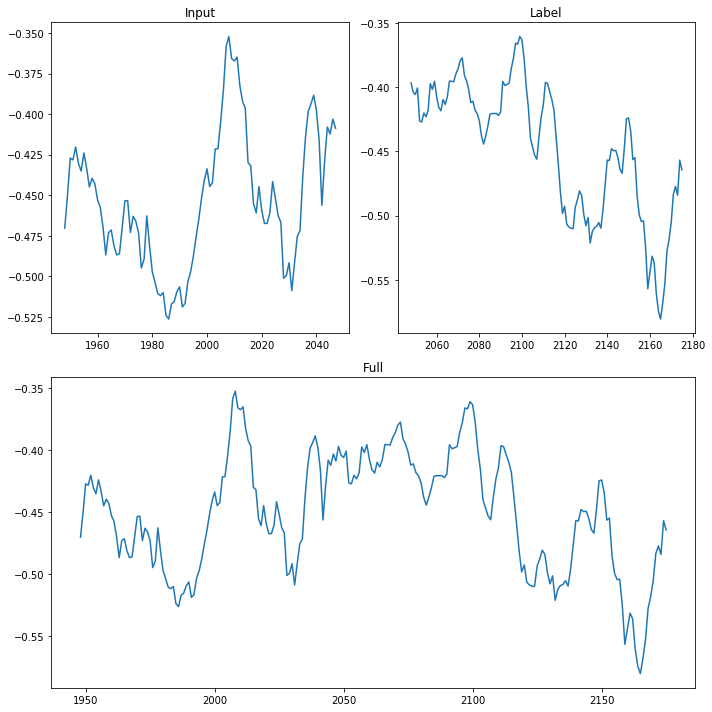

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

print(data.shape)

fig = plt.figure(figsize=(10,10))
gs = GridSpec(2,2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:])

ax1.plot(np.arange(1948,2048,1), data[0,0,1948:2048])
ax1.set_title('Input')

ax2.plot(np.arange(2048, 2176, 1), labels[0,0,:])
ax2.set_title('Label')

ax3.plot(np.arange(1948, 2176, 1), full[0,0,1948:])
ax3.set_title('Full')

plt.tight_layout()
plt.show()

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

split_idx = int(.75 * data.shape[0])

print(split_idx)
print(data.shape)
print(labels.shape)

train_data = DataLoader(TensorDataset(torch.Tensor(data[:split_idx, :, :]), torch.Tensor(labels[:split_idx, :, :])), batch_size=batch_size, shuffle=True)
valid_data = DataLoader(TensorDataset(torch.Tensor(data[split_idx:, :, :]), torch.Tensor(labels[split_idx:, :, :])), batch_size=batch_size, shuffle=False)

54594
(72793, 1, 2048)
(72793, 1, 128)


In [5]:
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.fft import rfft
from scipy import stats
from typing import Tuple, List

def get_norm_factor(full_lfp: np.ndarray) -> np.ndarray:
    norm_factor = []
    for i in range(full_lfp.shape[0]):
        lfp = np.squeeze(full_lfp[i,:,:].T)
        nfft = 2**7 # 128 samples
        f, Pxx = signal.welch(lfp, fs=1000, window='hamming', nperseg=nfft, scaling='spectrum')
        f = f.ravel()

        f_cutoff = max(np.argmax(Pxx),1)
        Pmax = Pxx[f_cutoff]
        idx = np.arange(f_cutoff,f.size)
        result = stats.linregress(np.log(f[idx]),np.log(Pxx[idx]))
        b = result.intercept
        a = -result.slope

        f_cutoff = np.exp((b-np.log(Pmax))/a)
        idx = f>f_cutoff
        Pfit = Pxx.copy()
        Pfit[idx] = np.exp(b)/f[idx]**a
        Pfit[~idx] = Pmax
        norm_factor.append(np.sqrt(Pmax/Pfit))
    norm_factor = np.stack(norm_factor)
    return norm_factor

def fft_loss(output: torch.Tensor, target: torch.Tensor, norm_factor: torch.Tensor) -> torch.Tensor:
    fft_data = torch.square((rfft(output, n=128).real - rfft(target, n=128).real))
    # print(norm_factor.shape)
    # print(fft_data.shape)
    loss = torch.sum(torch.mm(norm_factor, fft_data.T))
    # print(loss.shape)
    return loss

def train_model(model: nn.Module,
                training_loader: torch.utils.data.DataLoader,
                validation_loader: torch.utils.data.DataLoader,
                epochs: int,
                device: torch.device) -> Tuple[List[float], List[float]]:
    #splitting the dataloaders to generalize code
    data_loaders = {"train": training_loader, "val": validation_loader}
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
    # optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0)
    loss_func = nn.MSELoss()
    decay_rate = .9 #0.98 #decay the lr each step to 98% of previous lr
    lr_sch = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)
    validation_loss, training_loss = [], []

    """
    You can easily adjust the number of epochs trained here by changing the number in the range
    """
    for epoch in tqdm(range(epochs), position=0, leave=True):
        train_loss = 0.0
        val_loss = 0.0
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            for i, (x, y) in enumerate(data_loaders[phase]):
                x = x.to(device)
                output = model(x)
                y = y.to(device)
                norm_factor = torch.Tensor(get_norm_factor(x.to('cpu').detach().numpy())).to(device)
                loss = fft_loss(torch.squeeze(output), torch.squeeze(y), norm_factor)
                # loss = loss_func(torch.squeeze(output), torch.squeeze(y))
                #backprop
                optimizer.zero_grad()
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    # if i == 104 and epoch % 10 == 0:
                    #     tqdm.write('First Layer Gradient: {}'.format(model.conv1.weight.grad))

                running_loss += loss.item()

            if phase == 'train':
                train_loss = running_loss
                lr_sch.step()
                training_loss.append(train_loss)
            else:
                val_loss = running_loss
                validation_loss.append(val_loss)

        # shows total loss
        if epoch%5 == 0:
        # if True:
            tqdm.write('[%d] train loss: %.6f val loss: %.6f' % (epoch + 1, train_loss, val_loss))
    return training_loss, validation_loss

In [6]:
import copy
from lfp_prediction.models.LFPNet import FCN, CNN

epochs = 500

model = CNN(in_size=2048, h_size=500, out_size=128)
model_initial = copy.deepcopy(model)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
t_loss, v_loss = train_model(model, train_data, valid_data, epochs, device)

  0%|          | 0/500 [00:00<?, ?it/s]

[1] train loss: 842611784.234497 val loss: 148084645.718750
[6] train loss: 153098311.575928 val loss: 56847330.412109
[11] train loss: 147971654.566589 val loss: 56331379.132812
[16] train loss: 145838638.995361 val loss: 56065064.531250
[21] train loss: 144833808.487396 val loss: 58502785.595703
[26] train loss: 144062633.234406 val loss: 58961529.253906
[31] train loss: 143480604.029541 val loss: 60923044.410156
[36] train loss: 143167485.055664 val loss: 60328644.019531
[41] train loss: 142720418.447479 val loss: 62318042.210938
[46] train loss: 142860508.818512 val loss: 61764995.128906
[51] train loss: 142618669.028717 val loss: 61950644.355469
[56] train loss: 142675551.255005 val loss: 60553098.638672
[61] train loss: 142782533.658249 val loss: 62196848.093750
[66] train loss: 142642059.686798 val loss: 62629651.453125
[71] train loss: 142732391.115585 val loss: 62514826.746094
[76] train loss: 142683891.100433 val loss: 61630694.722656
[81] train loss: 142720236.958496 val los

In [7]:
# mat = io.loadmat(INVIVO_RAW_PATH)['LFP_seg']
#
# lfp = mat[0][0]
#
# freq_band = np.array([55, 100])
# z, a = signal.butter(4, freq_band, btype='bandpass', output='ba', fs=1000)
# ncfilt_lfp = signal.filtfilt(z, a, lfp, axis=0)
#
# test_input = torch.Tensor(lfp[:2048,:].reshape((1, 1, -1)).copy())
# # print(test_input)
#
# test_label = np.squeeze(ncfilt_lfp[2048:2148])
# model.eval()
# # torch.save(model.state_dict(), 'SGD_1024_noncausal_model.pth')
# test_input = test_input.to(device)
# output = model(test_input)
# output = np.squeeze(output.to("cpu").detach().numpy())
# # y = y.to("cpu").detach().numpy()
# test_input = np.squeeze(test_input.to("cpu").detach().numpy())
#
# test_input = signal.lfilter(z, a, test_input, axis=0)
# pred_noncausal = np.flip(output)
# base_noncausal = ncfilt_lfp[2048:2148,:]
#
#
# # print(pred_noncausal.shape)
# print(base_noncausal.shape)
# # print(y.shape)
# print(output.shape)

In [8]:
x, y = next(iter(valid_data))
model.eval()
x = x.to(device)
output = model(x)
x = x.to("cpu").detach().numpy()
output = output.to("cpu").detach().numpy()
y = y.to("cpu").detach().numpy()

print(x.shape)
print(y.shape)
print(output.shape)

(32, 1, 2048)
(32, 1, 128)
(32, 1, 128)


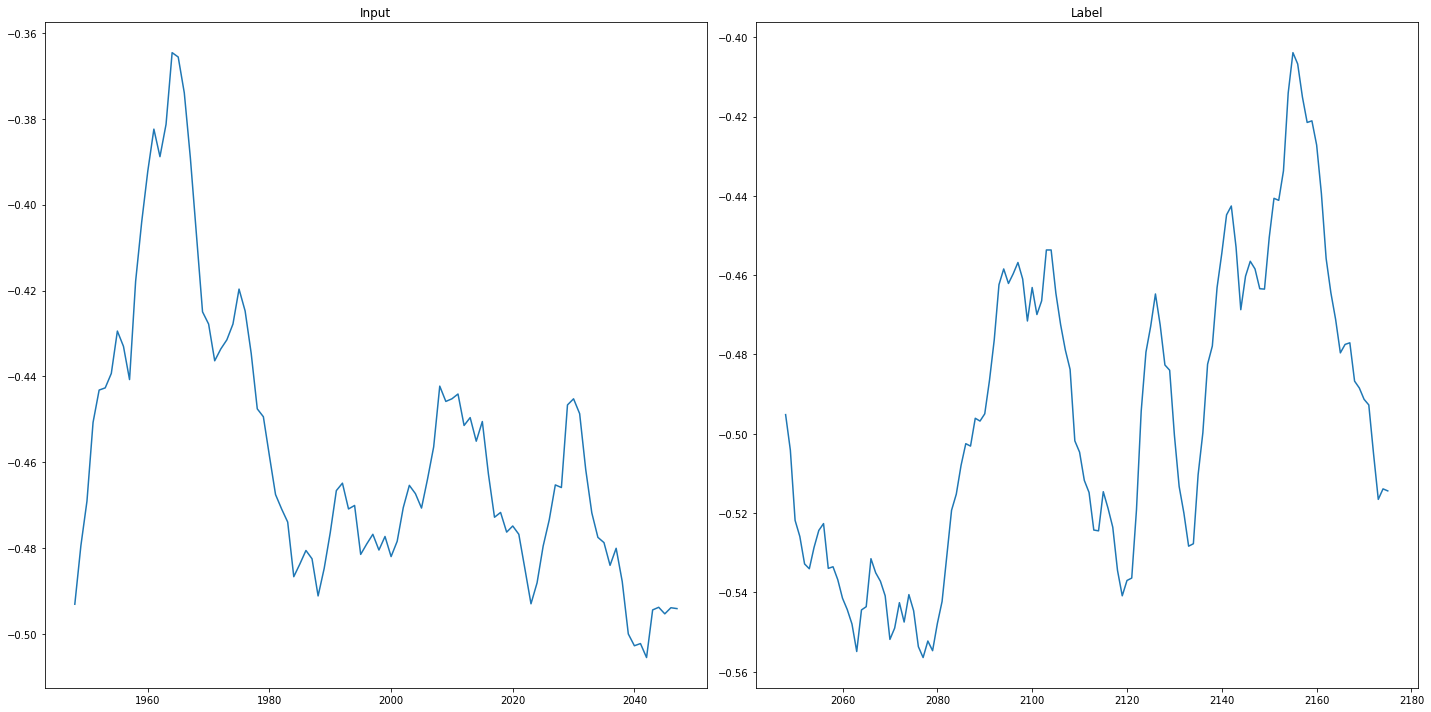

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.plot(np.arange(1948,2048,1), x[0,0,1948:2048])
ax1.set_title('Input')

ax2.plot(np.arange(2048, 2176, 1), y[0,0,:])
ax2.set_title('Label')

plt.tight_layout()
plt.show()

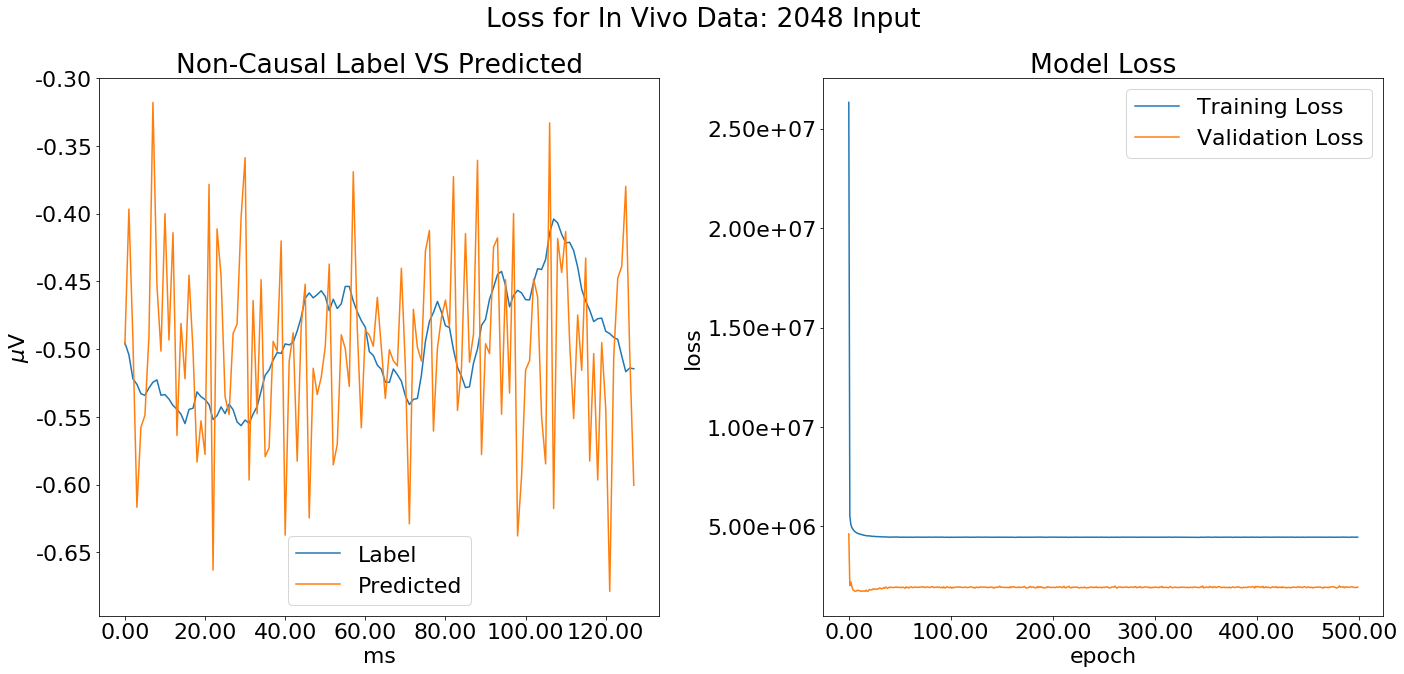

In [10]:
%matplotlib inline
from matplotlib.ticker import FormatStrFormatter

# scaled_t_loss = [l/split_idx for l in t_loss]
# scaled_v_loss = [l/(data.shape[0] - split_idx) for l in v_loss]

scaled_t_loss = [l/batch_size for l in t_loss]
scaled_v_loss = [l/batch_size for l in v_loss]

plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 22

fig, axs = plt.subplots(1,2)

# fig.suptitle('Loss for {}-{} Hz In Vivo: 2048 Input'.format(frequency_band[0], frequency_band[1]))
fig.suptitle('Loss for In Vivo Data: 2048 Input')

t = np.arange(0, 128, 1)

time_var = 128

axs[0].plot(t, y[0,0,:], label='Label')
axs[0].plot(t, output[0,0,:], label='Predicted')
# axs[0].set_ylim(bottom=-0.0075, top=0.0075)
axs[0].set_xlabel('ms')
axs[0].set_ylabel(r'$\mu$V')
axs[0].set_title('Non-Causal Label VS Predicted')
axs[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs[0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs[0].legend(loc='best')

axs[1].plot(np.arange(epochs), np.array(scaled_t_loss), label='Training Loss')
axs[1].plot(np.arange(epochs), np.array(scaled_v_loss), label='Validation Loss')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('loss')
axs[1].set_title('Model Loss')
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
axs[1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs[1].legend(loc='best')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()